# Latent space analysis - right hemisphere

In [1]:
# Imports
import torch
import pandas as pd
#from preprocessing import create_aims_set
from vae import *
from sklearn import metrics
import datasets

In [2]:
side='R'
data_dir = '/neurospin/dico/data/deep_folding/current/crops/CINGULATE/mask/sulcus_based/2mm/centered_combined/hcp/'

## Loading of the model

In [3]:
root_dir ='/neurospin/dico/lguillon/midl_22/run_2/'
model = VAE((1, 20, 40, 40), 75, depth=3)
model.load_state_dict(torch.load(root_dir + 'checkpoint.pt'))

<All keys matched successfully>

## Analysis

### Loading of test data

In [4]:
# fetch data 
test_csv = '/neurospin/dico/data/deep_folding/current/test.csv'
test_list = pd.read_csv(test_csv, header=None, usecols=[0], names=['subjects'])
test_list['subjects'] = test_list['subjects'].astype('str')

# encode data
tmp = pd.read_pickle(os.path.join(data_dir, f"{side}skeleton.pkl")).T
#tmp = tmp.rename(columns={0:'subjects'})
tmp.index.astype('str')

tmp = tmp.merge(test_list, left_on = tmp.index, right_on='subjects', how='right')
#tmp.merge(test_list, left_on = tmp.index, right_on='subjects', how='right')
filenames = list(test_list.subjects)
test_set = datasets.SkeletonDataset(dataframe=tmp, filenames=filenames)

In [5]:
test_loader = torch.utils.data.DataLoader(test_set, batch_size=1,
                                          shuffle=True, num_workers=0)

dico_set_loaders = {'test': test_loader}

In [6]:
device = torch.device("cuda", index=0)
model = model.to(device)

class_weights = torch.FloatTensor([1, 7]).to(device)
#class_weights = torch.FloatTensor([2, 7])
distance = nn.CrossEntropyLoss(weight=class_weights, reduction='sum')

# HCP -------- dataset_test_loader & benchmark
tester = ModelTester(model=model, dico_set_loaders=dico_set_loaders,
                     loss_func=distance, kl_weight=8, n_latent=75,
                     depth=3, skeleton=True, root_dir=root_dir)

results = tester.test()

losses = {loader_name:[results[loader_name][k][0] for k in results[loader_name].keys()] for loader_name in dico_set_loaders.keys()}
encoded = {loader_name:[results[loader_name][k][3] for k in results[loader_name].keys()] for loader_name in dico_set_loaders.keys()}

In [7]:
df_encoded = pd.DataFrame()

df_encoded['latent'] = encoded['test']

X = np.array(list(df_encoded['latent']))

In [8]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2).fit_transform(X)

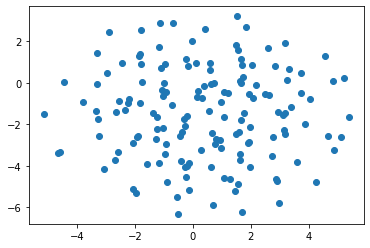

In [9]:
X_embedded = TSNE(n_components=2).fit_transform(X)
color_dict = {'test': 'blue', 'benchmark': 'magenta'}

x = [X_embedded[k][0] for k in range(150)]
y = [X_embedded[k][1] for k in range(150)]

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(x, y)
    
plt.show()

In [12]:
kmeans2d = KMeans(n_clusters=2, random_state=0).fit_predict(X)
metrics.silhouette_score(X, kmeans2d)

0.015552842

In [11]:
# Kmeans
from sklearn.cluster import KMeans
kmeans2d = KMeans(n_clusters=2, random_state=0).fit_predict(X_embedded)
metrics.silhouette_score(X_embedded, kmeans2d)

0.32434213

In [13]:
cluster_subjects = {list(results['test'].keys())[k][0]: 0  if kmeans2d[k]==0 else 1 for k in range(len(kmeans2d))}

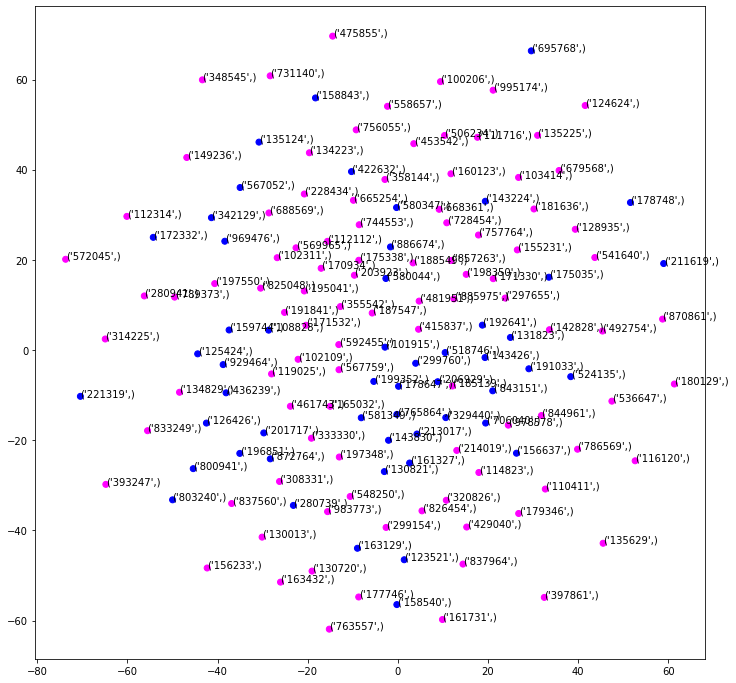

In [14]:
X_embedded = TSNE(n_components=2).fit_transform(X)
color_dict = {'test': 'blue', 'benchmark': 'magenta'}

x = [X_embedded[k][0] for k in range(150)]
y = [X_embedded[k][1] for k in range(150)]

col = ['blue' if kmeans2d[k]==0 else 'magenta' for k in range(len(kmeans2d))]

fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)
ax.scatter(x, y, c=col)

n = list(results['test'].keys()) 
for i, txt in enumerate(n):
    ax.annotate(txt, (x[i], y[i]))

In [15]:
# Kmeans
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, random_state=0).fit_predict(X)

In [16]:
from sklearn import metrics
metrics.silhouette_score(X, kmeans)

0.015552842

## Application on Tissier database

### Loading of labels

In [17]:
labels_set = pd.read_csv('/neurospin/dico/data/deep_folding/datasets/ACC_patterns/tissier_labels.csv')

In [18]:
labels_set.head()

,Sujet,OTS_left_continuous,OTS_left_interrupted_ant,OTS_left_interrupted_post,OTS_right_continuous,OTS_right_interrupted_ant,OTS_right_interrupted_post,ACC_left_3_levels_new,ACC_left_inter,ACC_right_3levels_new,...,ACC_right_3levels_ct,ACC_right_PCS_lenght_1rst_segment,ACC_interruption_1.1,ACC_right_PCS_lenght_2nd_segment,ACC_right_PCS_lenght_total,ACC_left_2level,ACC_right_2level,ACC_Asym3_from2,ACC_Asym3_from3,ACC_Asym2_from2
0,a0012,yes,no,no,yes,no,no,proeminent,non,absent,...,48.0,48.0,48.0,36.0,36.0,36.0,36.0,0,0,0
1,a0018,yes,no,no,no,no,yes,present,non,absent,...,48.0,48.0,36.0,36.0,36.0,36.0,0.0,0,0,460
2,a0019,yes,no,no,no,yes,no,absent,NaN,present,...,9.0,76.0,9.0,89.0,0.0,0.0,0.0,13,0,absent
3,a0022,no,no,yes,yes,no,no,proeminent,non,absent,...,11.0,9.0,11.0,4.0,1.0,0.0,0.0,5,1,proeminent
4,a0023,no,no,yes,no,no,yes,present,non,absent,...,NaN,14.0,1.0,15.0,54.0,0.0,0.0,1,53,0


In [19]:
dico_labels = {labels_set['Sujet'][k]: 0 if labels_set['ACC_right_2levels_new'][k]=='absent' else 1 for k in range(len(labels_set))}

In [20]:
df_tissier_labels = pd.DataFrame(data={'sub': list(dico_labels.keys()), 'cing':list(dico_labels.values())})

In [21]:
df_tissier_labels

,sub,cing
0,a0012,0
1,a0018,0
2,a0019,1
3,a0022,0
4,a0023,0
5,a0024,1
6,a0025,1
7,a0027,0
8,a0028,0
9,a0029,1


In [22]:
data_dir = "/neurospin/dico/data/deep_folding/current/crops/CINGULATE/mask/sulcus_based/2mm/centered_combined/"
subject_dir = "/neurospin/dico/data/deep_folding/current/"

test_list = pd.read_csv(os.path.join(subject_dir, 'test.csv'), header=None,
                            usecols=[0], names=['subjects'])
test_list['subjects'] = test_list['subjects'].astype('str')

tmp = pd.read_pickle(os.path.join(data_dir, "hcp", f"{side}skeleton.pkl")).T
tmp.index.astype('str')

tmp2 = pd.read_pickle(os.path.join(data_dir, "tissier_2018", f"{side}skeleton.pkl")).T
tmp2.index.astype('str')

tmp2 = tmp2.merge(df_tissier_labels, left_on=tmp2.index, right_on="sub", how="right")

tmp = tmp.merge(test_list, left_on = tmp.index, right_on='subjects', how='right')

filenames = list(test_list['subjects'])

hcp = datasets.SkeletonDataset(dataframe=tmp, filenames=filenames)

filenames2 = list(tmp2['sub'])
tissier = datasets.SkeletonDataset(dataframe=tmp2, filenames=filenames2)

labels = np.array(['hcp' for k in range(len(test_list))] \
         + ['tissier' for k in range(len(tmp2))])

In [23]:
test_loader = torch.utils.data.DataLoader(hcp, batch_size=1,
                                          shuffle=False, num_workers=0)
tissier = torch.utils.data.DataLoader(tissier, batch_size=1,
                                          shuffle=False, num_workers=0)

dico_set_loaders = {'hcp': test_loader, 'tissier': tissier}

In [24]:
device = torch.device("cuda", index=0)
model = model.to(device)

class_weights = torch.FloatTensor([2, 7]).to(device)
#class_weights = torch.FloatTensor([2, 7])
distance = nn.CrossEntropyLoss(weight=class_weights, reduction='sum')

# HCP -------- dataset_test_loader & benchmark
tester = ModelTester(model=model, dico_set_loaders=dico_set_loaders,
                     loss_func=distance, kl_weight=8, n_latent=75,
                     depth=3, skeleton=True, root_dir=root_dir)

results = tester.test()

losses = {loader_name:[results[loader_name][k][0] for k in results[loader_name].keys()] for loader_name in dico_set_loaders.keys()}
encoded = {loader_name:[results[loader_name][k][3] for k in results[loader_name].keys()] for loader_name in dico_set_loaders.keys()}

In [25]:
df_encoded = pd.DataFrame()

df_encoded['latent'] = encoded['tissier']

X = np.array(list(df_encoded['latent']))

In [26]:
labels_sub = [list(results['tissier'].keys())[k][0] for k in range(len(results['tissier']))]

In [27]:
labels_sub = [sub for sub in dico_labels.keys()]

In [28]:
labels_cing = [dico_labels[sub] for sub in labels_sub if sub in dico_labels.keys()]

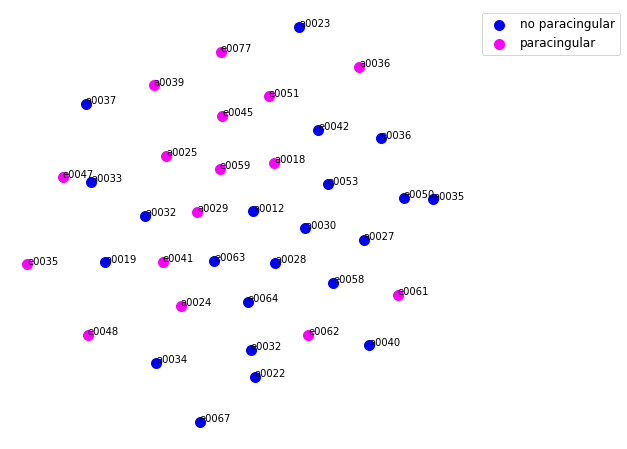

In [36]:
X_embedded = TSNE(n_components=2).fit_transform(X)
color_dict = {0: 'blue', 1: 'magenta'}
arr = X_embedded

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)

for g in [0, 1]:
    ix = np.where(np.array(labels_cing) == g)
    x = [arr[ix][k][0] for k in range(len(ix[0]))]
    y = [arr[ix][k][1] for k in range(len(ix[0]))]
    if g==0:
        g_lab = 'no paracingular'
    else:
        g_lab = 'paracingular'
    ax.scatter(x, y, c = color_dict[g], label = g_lab, s=100)

for i, txt in enumerate(filenames2):
    ax.annotate(txt, (arr[i][0], arr[i][1]))
    
plt.axis('off')    
ax.legend(fontsize=12)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)

plt.show()

In [39]:
# Kmeans
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, random_state=0).fit_predict(X_embedded)

In [31]:
np.unique(np.array(labels_cing), return_counts=True)

(array([0, 1]), array([22, 16]))

In [ ]:
16/38

In [41]:
metrics.accuracy_score(kmeans, labels_cing)

0.47368421052631576

In [43]:
kmeans = KMeans(n_clusters=2, random_state=0).fit_predict(X)
metrics.accuracy_score(kmeans, labels_cing)

0.42105263157894735